In [1]:
from dotenv import load_dotenv
import os
import dotenv
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader, Subset
import pytorch_lightning as pl
import torch.nn as nn
import torch.optim as optim
from pytorch_lightning import Trainer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import torch
import torch.nn as nn
import torch.optim as optim
import pytorch_lightning as pl
from lightning.pytorch.loggers import WandbLogger
import torchmetrics
import torch.utils.data as td
import torch
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import wandb


load_dotenv()
print(os.getenv("WANDB_API_KEY"))
wandb.login()


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


e1835b051dd702046d87e762dc3ae7fd34565328


wandb: Currently logged in as: giorgiobiancini (giorgiobiancini-roma-tre-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

# Dataset

In [2]:
class TensorDataset(td.Dataset):
    def __init__(self, data_dir, labels, max_frames=115):
        
        self.data_dir = data_dir
        self.labels = labels
        self.max_frames = max_frames

    def __len__(self):
        return len(self.data_dir)
    
    def __getitem__(self, item):
        tensor_path = self.data_dir[item]
        tensor = np.load(tensor_path)
        if tensor.shape[0] > self.max_frames:
            tensor = tensor[:self.max_frames]
        label = int(self.labels[item])
        
        tensor = np.transpose(tensor, (2, 0, 1))
        
        return {
            "tensor": torch.tensor(tensor, dtype=torch.float),
            "label": torch.tensor(label, dtype=torch.long)
        }


# DataLoader

In [3]:
class TensorDataLoader(pl.LightningDataModule):
    def __init__(self, data, batch_size, max_frames=115):
        super().__init__()
        self.data = data
        self.batch_size = batch_size
        self.max_frames = max_frames
        
        self.train = None
        self.val = None
        self.test = None

    def setup(self, stage: str = None):
        if stage not in ["train", "val", "test"]:
            raise ValueError(f"Invalid stage {stage}, expected 'train', 'val' or 'test'")
        if stage == "train":
            self.train = TensorDataset(self.data["tensor"].tolist(), self.data["label"].tolist())
            
        elif stage == "val":
            self.val = TensorDataset(self.data["tensor"].tolist(), self.data["label"].tolist())
            
        elif stage == "test":
            self.test = TensorDataset(self.data["tensor"].tolist(), self.data["label"].tolist())
            
    def train_dataloader(self) -> td.DataLoader:
        return td.DataLoader(self.train, batch_size=self.batch_size, shuffle=True, drop_last=True, num_workers=0)

    def val_dataloader(self) -> td.DataLoader:
        return td.DataLoader(self.val, batch_size=self.batch_size, shuffle=False, num_workers=0)

    def test_dataloader(self) -> td.DataLoader:
        return td.DataLoader(self.test, batch_size=1, shuffle=False, num_workers=0)

# Model

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl
import torchmetrics

class Model(pl.LightningModule):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.SiLU()
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.SiLU()
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128)
        )

        self.max_pool = nn.MaxPool2d(kernel_size=1, stride=1)
        self.avg_pool = nn.AvgPool2d(kernel_size=1, stride=1)
        self.attn_conv = nn.Conv2d(in_channels=256, out_channels=128, kernel_size=1, stride=1)
        self.adapt_avg_pool = nn.AdaptiveAvgPool2d((8, 8))

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(128 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)

        # Spatial Attention
        maxp_x = self.max_pool(x)
        avgp_x = self.avg_pool(x)

        spat_attn = self.attn_conv(torch.cat([maxp_x, avgp_x], dim=1))
        new_x = torch.mul(spat_attn, x)
        new_x = self.adapt_avg_pool(new_x)
        new_x = F.silu(new_x)

        feat = self.flatten(new_x)
        feat = self.fc1(feat)
        feat = F.silu(feat)
        feat = self.fc2(feat)

        return feat

    def compute_loss(self, yhat, y):
        y = y.view_as(yhat)
        pos_weight = torch.tensor([2.0], device=yhat.device)  # Cambia in base allo squilibrio
        return F.binary_cross_entropy_with_logits(yhat, y, pos_weight=pos_weight)

    def training_step(self, batch, batch_idx):
        x, y = batch["tensor"], batch["label"]
        yhat = self(x)
    
        loss = self.compute_loss(yhat, y.type_as(yhat))
        auc = torchmetrics.AUROC(task='binary')(torch.sigmoid(yhat), y)
    
        self.log("train_loss", loss, prog_bar=True, on_epoch=True, logger=True, on_step=False)
        self.log("train_auc", auc, prog_bar=False, on_epoch=True, logger=True, on_step=False)
    
        return {'loss': loss}

    def validation_step(self, batch, batch_idx):
        x, y = batch["tensor"], batch["label"]
        yhat = self(x)

        loss = self.compute_loss(yhat, y.type_as(yhat))
        auc = torchmetrics.AUROC(task='binary')(torch.sigmoid(yhat), y)

        self.log("val_loss", loss, prog_bar=True, on_epoch=True, logger=True, on_step=False)
        self.log("val_auc", auc, prog_bar=False, on_epoch=True, logger=True, on_step=False)

        return {'val_loss': loss}

    def test_step(self, batch, batch_idx):
        x, y = batch["tensor"], batch["label"]
        yhat = self(x)

        loss = self.compute_loss(yhat, y.type_as(yhat))
        auc = torchmetrics.AUROC(task='binary')(torch.sigmoid(yhat), y)

        self.log("test_loss", loss, prog_bar=True, on_epoch=True, logger=True, on_step=False)
        self.log("test_auc", auc, prog_bar=False, on_epoch=True, logger=True, on_step=False)

        return {'test_loss': loss}

    def predict_step(self, batch):
        x, _ = batch["tensor"], batch["label"]
        yhat = self(x)

        return {"predictions": yhat.detach().cpu().numpy()}

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=5e-4, weight_decay=1e-6)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, 100, eta_min=1e-5)
        return {"optimizer": optimizer, "lr_scheduler": scheduler}



# Data preprocessing

In [5]:
import os
import numpy as np
import pandas as pd

def data_preprocessing(data_dir, users, max_frames=115):
    data = []
    for user in users:
        user_dir = os.path.join(data_dir, user)
        tensors_dir = os.path.join(user_dir, "tensors")
        print(tensors_dir)
        for tensor_file in os.listdir(tensors_dir):
            tensor_path = os.path.join(tensors_dir, tensor_file)
            tensor = np.load(tensor_path)
            if tensor.shape[0] < max_frames:
                print(f"Skipping {tensor_file} due to insufficient frames")
                continue
            label = tensor_file.split("_")[3]
            if int(label) < 5:
                label = 0
            else:
                label = 1
            data.append({"tensor": tensor_path, "label": label})
    return pd.DataFrame(data)

# Evaluate Model

In [6]:
def evaluate_model(model, test_dl):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch in test_dl:
            x, y = batch["tensor"], batch["label"]
            yhat = model(x)
            preds = torch.sigmoid(yhat).round().cpu().numpy()
            with open("predictions.txt", "a") as f:
                f.write(f"prediction {yhat}, label predicted {preds}, label true {y}\n")
            all_preds.extend(preds)
            all_labels.extend(y.cpu().numpy())
    
    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    
    # Plot confusion matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()
    
    return cm

# Leave-One-Out Training

In [7]:
def leave_one_out_training(data_dir, max_epochs=10):
    torch.cuda.empty_cache()
    
    users = sorted(os.listdir(data_dir))
    all_fold_metrics = []

    for i, user in enumerate(users):
        print(f"\n=== Leave-One-Out Fold {i+1}/{len(users)} ===")
        
        test_user_path = [user]
        train_user_path = [x for x in users if x != user]
        
        df_train = data_preprocessing(data_dir, train_user_path)
        df_test = data_preprocessing(data_dir, test_user_path)
        
        df_train, df_val = train_test_split(df_train, test_size=0.2, random_state=42)
        
        train_dm = TensorDataLoader(df_train, batch_size=32)
        val_dm = TensorDataLoader(df_val, batch_size=32)
        test_dm = TensorDataLoader(df_test, batch_size=1)
        
        train_dm.setup("train")
        val_dm.setup("val")
        test_dm.setup("test")
        
        train_dl = train_dm.train_dataloader()
        val_dl = val_dm.val_dataloader()
        test_dl = test_dm.test_dataloader()
        
        early_stop = pl.callbacks.EarlyStopping(monitor='val_loss', patience=5, mode='min', verbose=True)
        
        trainer = pl.Trainer(devices=1, accelerator="auto", precision=16, callbacks=[early_stop], max_epochs=max_epochs, gradient_clip_val=2, enable_progress_bar=True)
        
        model = Model()
        trainer.fit(model, train_dataloaders=train_dl, val_dataloaders=val_dl)
        
    print("\n=== Evaluating on Test Set ===")
    cm = evaluate_model(model, test_dl)
        
    all_fold_metrics.append(cm)
    
    return all_fold_metrics


# Classic Training (1 user for testing)

In [8]:
def classic_train(data_dir, max_epochs=10):
    torch.cuda.empty_cache()

    users = sorted(os.listdir(data_dir))

    # Pick random user for testing
    test_user = np.random.choice(users, 1)

    df_test = data_preprocessing(data_dir, test_user)
    
    while df_test is None:
        test_user = np.random.choice(users, 1)
        df_test = data_preprocessing(data_dir, test_user)

    print(f"user {test_user[0]} is selected for testing, tensors= {len(df_test)}")
    all_fold_metrics = []

    # Join users to data_dir
    users = [x for x in users if x != test_user[0]]
    df_train = data_preprocessing(data_dir, users)

    # If df_train is None, handle the error
    if df_train is None:
        raise ValueError("Training data preprocessing returned None")

    df_train, df_val = train_test_split(df_train, test_size=0.2, random_state=42, stratify=df_train["label"])

    train_dm = TensorDataLoader(df_train, batch_size=32)
    val_dm = TensorDataLoader(df_val, batch_size=32)
    test_dm = TensorDataLoader(df_test, batch_size=1)

    train_dm.setup("train")
    val_dm.setup("val")
    test_dm.setup("test")

    train_dl = train_dm.train_dataloader()
    val_dl = val_dm.val_dataloader()
    test_dl = test_dm.test_dataloader()

    early_stop = pl.callbacks.EarlyStopping(monitor='val_loss', patience=99, mode='min', verbose=True)
    
    wabd_logger = WandbLogger(log_model="all", project="dl_emotion_test", name="classic_train")

    trainer = pl.Trainer(devices=1, accelerator="auto", precision=32, callbacks=[early_stop], max_epochs=max_epochs, gradient_clip_val=2, enable_progress_bar=True, logger=wabd_logger)

    model = Model()
    trainer.fit(model, train_dataloaders=train_dl, val_dataloaders=val_dl)

    print("\n=== Evaluating on Test Set ===")
    cm = evaluate_model(model, test_dl)

    all_fold_metrics.append(cm)

    return all_fold_metrics

# Start training

data/users\ee154cdd451335215d8cd3355a7338f99a4c8dc1\tensors
user ee154cdd451335215d8cd3355a7338f99a4c8dc1 is selected for testing, tensors= 99
data/users\0ca7288b551d6863ade0cca0248bbcbe6e600fe0\tensors
Skipping 0ca7288b551d6863ade0cca0248bbcbe6e600fe0_inquietanti_04504f6d-bd2b-44d5-842f-e9e7b2d95d6e.jpg_7_3_2_2.npy due to insufficient frames
Skipping 0ca7288b551d6863ade0cca0248bbcbe6e600fe0_inquietanti_07fbbb3c-26fa-41f2-a461-9a48601fc48a.jpg_8_3_2_3.npy due to insufficient frames
Skipping 0ca7288b551d6863ade0cca0248bbcbe6e600fe0_inquietanti_14aeb0ec-d858-46a3-b70c-5c4affefdce5.jpg_7_3_1_1.npy due to insufficient frames
Skipping 0ca7288b551d6863ade0cca0248bbcbe6e600fe0_inquietanti_2ab300cc-0efa-4682-8d2d-a2cb20dad16d.jpg_9_1_2_1.npy due to insufficient frames
Skipping 0ca7288b551d6863ade0cca0248bbcbe6e600fe0_inquietanti_2c814275-a3cd-4629-ba63-8bec1aa3a39a.jpg_7_2_2_3.npy due to insufficient frames
Skipping 0ca7288b551d6863ade0cca0248bbcbe6e600fe0_inquietanti_332df050-53fa-4fde-bb43-3

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4070 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | conv1          | Sequential        | 960    | train
1 | conv2          | Sequential        | 18.6 K | train
2 | conv3          | Sequential        | 74.1 K | train
3 | max_pool       | MaxPool2d         | 0      | train
4 | avg_pool       | AvgPool2d         | 0      | train
5 | attn_conv      | Conv2d            | 32.9 K | train
6 | adapt_avg_pool | AdaptiveAvgPool2d | 0      | train
7 | flatten        | Flatten           | 0      | train
8 | fc1            | Linear            | 1.0 M  | train
9 | fc2            | Linear            | 129    | train
-------------------------------------------------------------
1.2 M     Trainable params
0         Non-trainable params
1.2 M     Total params
4.702     Total estimated model params size (MB)
20        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

C:\Users\giorg\DataspellProjects\dl_project\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


C:\Users\giorg\DataspellProjects\dl_project\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 54/54 [00:01<00:00, 46.04it/s, v_num=6ptw]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 54/54 [00:01<00:00, 38.25it/s, v_num=6ptw, val_loss=0.834, train_loss=0.828]

Metric val_loss improved. New best score: 0.834


Epoch 1: 100%|██████████| 54/54 [00:01<00:00, 51.22it/s, v_num=6ptw, val_loss=0.834, train_loss=0.828]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 54/54 [00:01<00:00, 41.15it/s, v_num=6ptw, val_loss=0.816, train_loss=0.786]

Metric val_loss improved by 0.017 >= min_delta = 0.0. New best score: 0.816


Epoch 2: 100%|██████████| 54/54 [00:01<00:00, 52.65it/s, v_num=6ptw, val_loss=0.816, train_loss=0.786]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 54/54 [00:01<00:00, 43.03it/s, v_num=6ptw, val_loss=0.783, train_loss=0.786]

Metric val_loss improved by 0.033 >= min_delta = 0.0. New best score: 0.783


Epoch 3: 100%|██████████| 54/54 [00:01<00:00, 49.62it/s, v_num=6ptw, val_loss=0.783, train_loss=0.786]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 54/54 [00:01<00:00, 39.83it/s, v_num=6ptw, val_loss=0.766, train_loss=0.777]

Metric val_loss improved by 0.017 >= min_delta = 0.0. New best score: 0.766


Epoch 4: 100%|██████████| 54/54 [00:01<00:00, 48.68it/s, v_num=6ptw, val_loss=0.766, train_loss=0.777]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 54/54 [00:01<00:00, 51.22it/s, v_num=6ptw, val_loss=0.772, train_loss=0.770]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 54/54 [00:01<00:00, 49.62it/s, v_num=6ptw, val_loss=0.776, train_loss=0.768]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 54/54 [00:01<00:00, 51.72it/s, v_num=6ptw, val_loss=0.770, train_loss=0.771]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 54/54 [00:01<00:00, 41.40it/s, v_num=6ptw, val_loss=0.760, train_loss=0.762]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.760


Epoch 8: 100%|██████████| 54/54 [00:01<00:00, 51.73it/s, v_num=6ptw, val_loss=0.760, train_loss=0.762]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 54/54 [00:01<00:00, 42.05it/s, v_num=6ptw, val_loss=0.757, train_loss=0.768]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.757


Epoch 9: 100%|██████████| 54/54 [00:01<00:00, 53.10it/s, v_num=6ptw, val_loss=0.757, train_loss=0.768]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 10: 100%|██████████| 54/54 [00:01<00:00, 53.11it/s, v_num=6ptw, val_loss=0.771, train_loss=0.756]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 11: 100%|██████████| 54/54 [00:01<00:00, 53.23it/s, v_num=6ptw, val_loss=0.765, train_loss=0.757]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 11: 100%|██████████| 54/54 [00:01<00:00, 43.43it/s, v_num=6ptw, val_loss=0.751, train_loss=0.749]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.751


Epoch 12: 100%|██████████| 54/54 [00:01<00:00, 53.24it/s, v_num=6ptw, val_loss=0.751, train_loss=0.749]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 13: 100%|██████████| 54/54 [00:01<00:00, 48.95it/s, v_num=6ptw, val_loss=0.779, train_loss=0.743]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 13: 100%|██████████| 54/54 [00:01<00:00, 40.29it/s, v_num=6ptw, val_loss=0.748, train_loss=0.746]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.748


Epoch 14: 100%|██████████| 54/54 [00:01<00:00, 52.51it/s, v_num=6ptw, val_loss=0.748, train_loss=0.746]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 15: 100%|██████████| 54/54 [00:00<00:00, 54.23it/s, v_num=6ptw, val_loss=0.758, train_loss=0.739]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 16: 100%|██████████| 54/54 [00:01<00:00, 52.01it/s, v_num=6ptw, val_loss=0.758, train_loss=0.756]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 17: 100%|██████████| 54/54 [00:01<00:00, 53.70it/s, v_num=6ptw, val_loss=0.768, train_loss=0.739]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 18: 100%|██████████| 54/54 [00:01<00:00, 53.58it/s, v_num=6ptw, val_loss=0.757, train_loss=0.753]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 19: 100%|██████████| 54/54 [00:01<00:00, 53.49it/s, v_num=6ptw, val_loss=0.758, train_loss=0.741]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 19: 100%|██████████| 54/54 [00:01<00:00, 43.69it/s, v_num=6ptw, val_loss=0.740, train_loss=0.7

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 0.740


Epoch 20: 100%|██████████| 54/54 [00:00<00:00, 54.71it/s, v_num=6ptw, val_loss=0.740, train_loss=0.738]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 21: 100%|██████████| 54/54 [00:01<00:00, 51.77it/s, v_num=6ptw, val_loss=0.749, train_loss=0.727]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 22: 100%|██████████| 54/54 [00:01<00:00, 52.67it/s, v_num=6ptw, val_loss=0.771, train_loss=0.737]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 23: 100%|██████████| 54/54 [00:00<00:00, 54.08it/s, v_num=6ptw, val_loss=0.877, train_loss=0.722]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 24: 100%|██████████| 54/54 [00:00<00:00, 55.23it/s, v_num=6ptw, val_loss=0.758, train_loss=0.724]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 24: 100%|██████████| 54/54 [00:01<00:00, 44.68it/s, v_num=6ptw, val_loss=0.738, train_loss=0.728]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.738


Epoch 25: 100%|██████████| 54/54 [00:01<00:00, 52.32it/s, v_num=6ptw, val_loss=0.738, train_loss=0.728]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 26: 100%|██████████| 54/54 [00:01<00:00, 53.47it/s, v_num=6ptw, val_loss=0.770, train_loss=0.714]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 27: 100%|██████████| 54/54 [00:00<00:00, 54.85it/s, v_num=6ptw, val_loss=0.761, train_loss=0.725]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 28: 100%|██████████| 54/54 [00:01<00:00, 51.52it/s, v_num=6ptw, val_loss=0.777, train_loss=0.714]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 29: 100%|██████████| 54/54 [00:00<00:00, 54.59it/s, v_num=6ptw, val_loss=0.753, train_loss=0.707]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 30: 100%|██████████| 54/54 [00:01<00:00, 51.19it/s, v_num=6ptw, val_loss=0.790, train_loss=0.715]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 31: 100%|██████████| 54/54 [00:01<00:00, 53.40it/s, v_num=6ptw, val_loss=0.773, train_loss=0.6

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 54/54 [00:01<00:00, 31.45it/s, v_num=6ptw, val_loss=1.670, train_loss=0.158]

=== Evaluating on Test Set ===


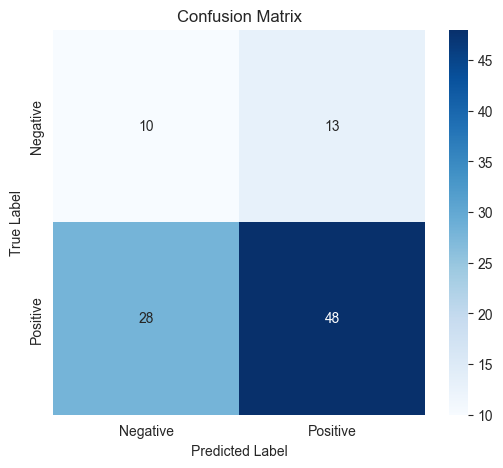

[array([[10, 13],
        [28, 48]], dtype=int64)]

In [9]:
classic_train("data/users", 100)